# Fit Tutorial
Demonstrates performing a fit to a single-parameter model.
This generates a synthetic mortality rate and then
fits that mortality.

The first step is to load all the libraries. This requires
having all of these libraries installed, including
both Cascade and Dismod-AT in a Docker container.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from math import nan, inf
from pathlib import Path
import numpy as np
import pandas as pd
import pytest

import matplotlib.pyplot as plt
# Make the plots bigger.
plt.rcParams['figure.figsize'] = [10, 8]

# These are all of the classes we need from Cascade-AT.
from cascade.model import (
    Session, Model, DismodGroups, SmoothGrid, Var, Covariate,
    Uniform, Gaussian
)
from cascade.stats.compartmental import siler_default, total_mortality_solution

In [2]:
# Use Siler mortality as our known true. This is a function of age,
# as presented, but it's defined over ages and times.
mortality = siler_default()
print(f"Mortality as a function of age, "
      f"at 0 {mortality(0):.4f} and at 20 {mortality(20):.4f}")

Mortality as a function of age, at 0 0.2032 and at 20 0.0045


Dismod-AT is a random effects model where the micro-level is the data and the macro-level
is the location where that data was observed. Dismod-AT assumes the locations
form a hierarchy and that, for any fit or predict, there is one parent
location. All data measured within the children of that parent location
will be included in the fit.

Specify locations as a Pandas DataFrame with columns for the name, location id as an integer, and the parent location as an integer. The name is purely cosmetic.

In [3]:
parent_location = 1
locations = pd.DataFrame(dict(
    name=["global"],
    parent=[nan],
    c_location_id=[parent_location],
))

## Make Data Using Dismod-AT Predict
The siler distribution is the theoretically-known rate.
Use the Dismod-AT predict function to create integrands
such as prevalence, with-condition, or mtother, from this
base rate.

The input to Dismod-AT Predict is a representation of
a continuous rate as an interpolation on a grid. Make a grid
that has yearly age points and is defined for one year in time.
The way Dismod-AT handles interpolation, all times outside
the bounds of the grid points are constant at the nearest
grid point value, so this means the rate is constant in time
across all times, but still varies by age.

In [4]:
age_points = 121
omega = Var([np.linspace(0, 120, age_points), [2000]])
for age, time in omega.age_time():
    omega[age, time] = mortality(age)

While this model has only one rate, Dismod-AT models can have five rates.
We put this rate into a larger structure, called a `DismodGroups`,
so that it knows which rate we're giving it.

In [5]:
model_variables = DismodGroups()
model_variables.rate["omega"] = omega

Dismod-AT predict calculates values of integrands at different ages
and times. We need to tell it what we want it to calculate.
This looks a lot like how we specify data to a Dismod-AT fit.
This example asks for the fraction of susceptibles
and for mtother, which should be exactly the rate we put in
as omega, given that the lower and upper ages are the same
and lower and upper times are the same.

In [6]:
data_cnt = 60
avgints = pd.DataFrame(dict(
    integrand="susceptible",
    location=parent_location,
    age_lower=np.linspace(0, 120, data_cnt),
    age_upper=np.linspace(0, 120, data_cnt),
    time_lower=2000,
    time_upper=2000,
))
avgints = pd.concat([avgints, avgints.assign(integrand="mtother")])

Those are the inputs for running Dismod-AT predict. The next
step is to start a Dismod-AT session and run predict.
A Dismod-AT session communicates with Dismod-AT running underneath.

In [7]:
session = Session(locations, parent_location, Path("fit0.db"))
session.set_option(ode_step_size=1)

Note the `ode_step_size=1`. This is the step size for predict.
We can play with this to understand how step size affects
fit accuracy, because a Dismod-AT fit is built upon
running predict over and over again during optimization.

Prediction returns two sets of data, the data points
requested and those that *could not be predicted*
because they were associated with covariates that are
outliered. No such covariates are in this model, so
that list will be empty.

In [8]:
predicted, not_predicted = session.predict(model_variables, avgints, parent_location)
assert not_predicted.empty and not predicted.empty
print(f"Predicted outcome with columns {', '.join(str(pc) for pc in predicted.columns)}")

Predicted outcome with columns predict_id, sample_index, avg_integrand, location, integrand, age_lower, age_upper, time_lower, time_upper


The predictions are a Pandas DataFrame with the columns shown. They will
match the avgints, so there are two sets of outcomes in this case,
mtother and susceptibles. This is now our data.

Let's fit that data. This entails making a Model and setting its
priors.

In [10]:
nonzero_rates = ["omega"]
model = Model(nonzero_rates, parent_location)
model.rate["omega"] = SmoothGrid([np.linspace(0, 120, age_points), [2000]])
for a, t, dage, dtime in model.rate["omega"].age_time_diff():
        target = omega(a, t)
        priors.value[a, t] = Uniform(mean=target, upper=target + 5, lower=0)
        priors.dage[a, t] = Gaussian(mean=0, standard_deviation=50, lower=-5, upper=5)
        priors.dtime[a, t] = Gaussian(mean=0, standard_deviation=0.1, lower=-5, upper=5)

That's the whole model. We could set the standard deviation on the
age-difference priors from the forward age difference if we wanted,
but it's enough to let them have a very large standard deviation.

While that was 8 lines, the output of predict needs some
help to look like input data.

In [12]:
data = predicted.drop(columns=["sample_index", "predict_id"]) \
    .rename(columns={"avg_integrand": "mean"})
data = data.assign(density="gaussian", std=0.3, eta=1e-4, nu=nan)

# It doesn't matter when the times are, because the system is constant
# across time.
data.loc[:, "time_lower"] = np.random.randint(1990, 2015, size=len(data))
# We can add some range to ages and times if we want.
add_some_range_to_times = 0
add_size = add_some_range_to_times * np.random.random(size=len(data))
data.loc[:, "time_upper"] = data.loc[:, "time_lower"] + add_size

# Want to intentionally take a data range and make it wrong?
mess_factor = 1  # 1 means leave it alone.
data.loc[(data.age_lower > 20) & (data.age_lower < 40) & (data.integrand == "mtother"), "mean"] = \
    mess_factor * data.loc[(data.age_lower > 20) & (data.age_lower < 40), "mean"]

That's all the parts for a fit: model with priors and data.

In [14]:
result = session.fit(model, data, initial_guess=model_variables)
fit_omega = result.fit.rate["omega"]

The resulting fit contains several parts.

 * `fit` - This has the same structure as the `model_variables` above.
 * `prior_residuals` - These are residuals and lagrange values for all priors.
 * `data_residuals` - Residuals on the input data uncertainty.
 * `fit_data` - The data that was included in the fit.
 * `excluded_data` - Which data was excluded from the fit, due to being
   held out or having covariates that are outliered.
   
The value residuals should be small, unless we intentionally
skewed the other-cause mortality with `mess_factor`.

In [16]:
value_residuals = list()
for age, time in fit_omega.age_time():
    value_residuals.append([age, float(fit_omega[age, time] - omega[age, time])])
# Makes an age column and a time column.
value_residuals = np.array(value_residuals).T

In [17]:
def plot_mortality(continuous_mortality, result, data, value_residuals):
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    ax = fig.add_subplot(gs[0, 0])
    x = np.linspace(0, 120, 241)
    slabel, = ax.plot(x, continuous_mortality(x), label="siler")
    omega_fit = result.fit.rate["omega"]
    flabel, = ax.plot(x, omega_fit(x, 2000), label="fit")
    mtother_data = data[data.integrand == "mtother"]
    dlabel = ax.scatter(mtother_data.age_lower.values, mtother_data["mean"].values, label="data")
    ax.legend(handles=[slabel, flabel, dlabel])
    ax.set_xlim([0, 70])
    ax.set_ylim([0, .2])
    ax.set_xlabel("age")
    ax.set_ylabel("rate")

    ax01 = fig.add_subplot(gs[0, 1])
    ax01.scatter(value_residuals[0], value_residuals[1])
    ax01.set_xlabel("age")
    ax01.set_ylabel("absolute residual")

    ax10 = fig.add_subplot(gs[1, 0])
    xkids = np.linspace(0, 20, 50)
    slabel, = ax10.plot(xkids, mortality(xkids), label="siler")
    # olabel, = ax10.plot(xkids, omega(xkids, 2000), label="omega")
    omega_fit = result.fit.rate["omega"]
    flabel, = ax10.plot(xkids, omega_fit(xkids, 2000), label="fit")
    ax10.legend(handles=[slabel, flabel])
    # ax.set_xlim([0, 70])
    # ax.set_ylim([0, .2])
    ax10.set_xlabel("age")
    ax10.set_ylabel("rate")

    ax11 = fig.add_subplot(gs[1, 1])
    ax11.scatter(value_residuals[0][:5], value_residuals[1][:5])
    ax11.set_xlabel("age")
    ax11.set_ylabel("absolute residual")

    plt.show()

/Users/ajd27/.local/share/virtualenvs/cascade-Tdl9WHR_/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


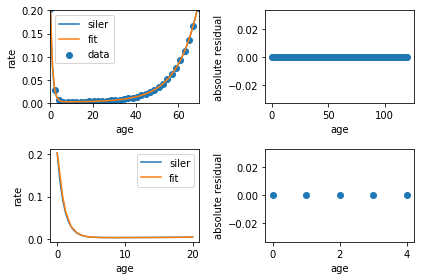

In [18]:
plot_mortality(mortality, result, data, value_residuals)